# Pre trained network
![imagen](https://www.researchgate.net/publication/336874848/figure/fig1/AS:819325225144320@1572353764073/Illustrations-of-transfer-learning-a-neural-network-is-pretrained-on-ImageNet-and.png)

Estas son las arquitecturas de redes neuronales más utilizadas en la comunidad. Para más detalle sobre el funcionamiento de cada red, consultar el [Hands on Machine Learning for Python](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch14.html#cnn_chapter).
* VGG-16
* VGG-19
* Inception V3
* XCeption
* ResNet-50

Las redes se pueden incorporar entrenadas, o sin entrenar.

## ResNet50V2

<img src="./img/ResNet50.png" alt="drawing" width="600"/>

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import cv2

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

In [4]:

'''
imagenet es un corpus de imagenes con el que se ha clasificado el ResNet50V2
http://www.image-net.org/

Cargamos toda la red ya entrenada, y la usaremos para predecir
include_top=True --> Para que incluya la fully connected layer.
include_top=False --> Desarrollamos la fully connected layer
ojo el input shape que sea el de las imagenes que introduciremos. Esta limitado a imagenes de tamaño n
classifier_activation se usa si include_top=True
'''

base_model = ResNet50V2(input_shape=(224, 224,3),
                        include_top=True,
                        weights="imagenet",
                        classifier_activation="softmax")

102869336/102869336 [==============================] - 22s 0us/step


In [5]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

Cargamos algunas imagenes desde local, para ver qué tal funciona la red ResNet50V2 ya entrenada.

In [20]:
import os

tipos = []

def read_data(path):
    X = []

    for file in [file for file in os.listdir(path) if file.endswith(".jpg")]:
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (224, 224))
        print(path + '/' + file)
        tipos.append(file)
        
        X.append(smallimage)

    return np.array(X)
    

x_figs = read_data('img')

# Procesar las imagenes tal y como entran en el modelo
x_test = preprocess_input(x_figs)
print(x_test.shape)

img/bear-1.jpg
img/cat.8016.jpg
img/cat.8037.jpg
img/dog.11856.jpg
img/dog.11857.jpg
img/horse.jpg
img/karate.jpg
img/pizza.jpg
(8, 224, 224, 3)


In [55]:
def plot_image(i, class_predicted, class_prob, true_label, img):
  img = img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  plt.xlabel(f"{class_predicted} {class_prob:.2f} ({true_label})")

def plot_value_array(predictions_array, predictions_labels):
  #predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(len(predictions_labels)),labels = predictions_labels)
  plt.yticks([])
  thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  plt.xlabel("top-5 predicciones")

  #thisplot[predicted_label].set_color('red')
  #thisplot[true_label].set_color('blue')

1/1 [==============================] - 0s 465ms/step


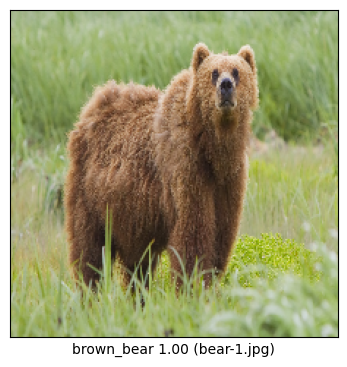

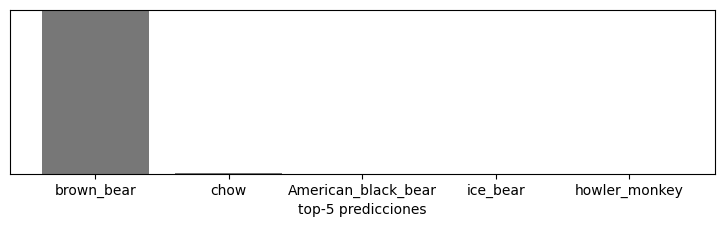

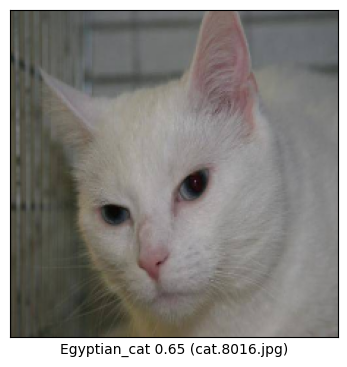

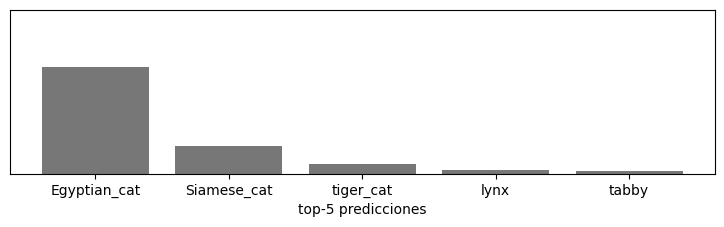

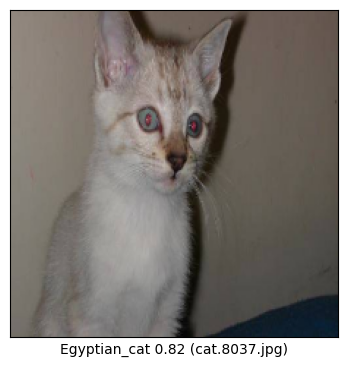

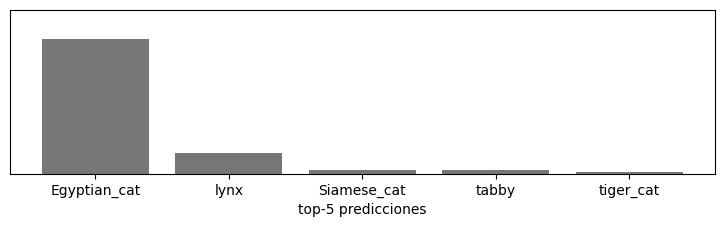

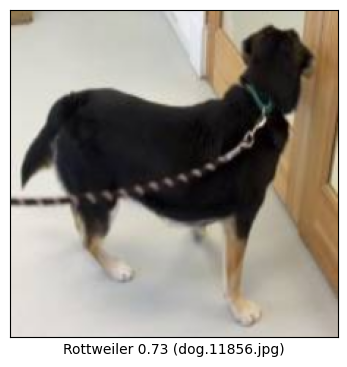

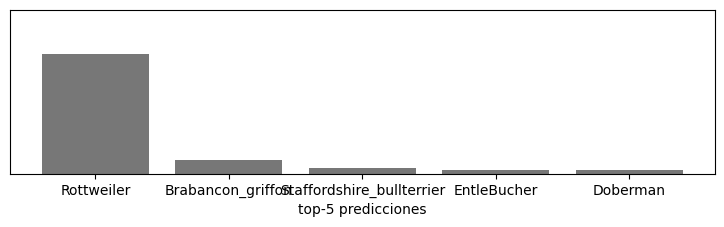

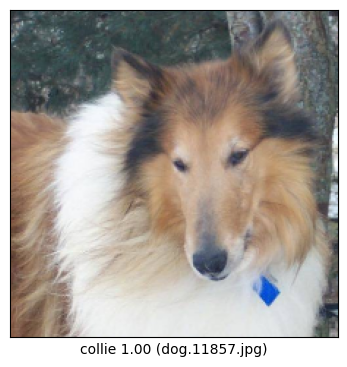

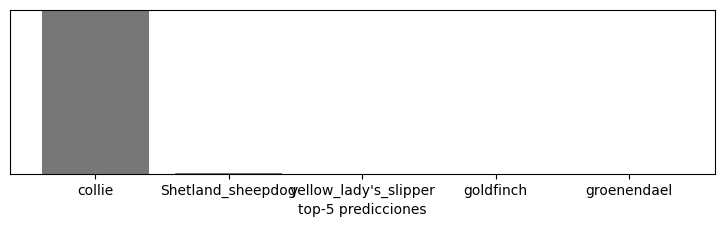

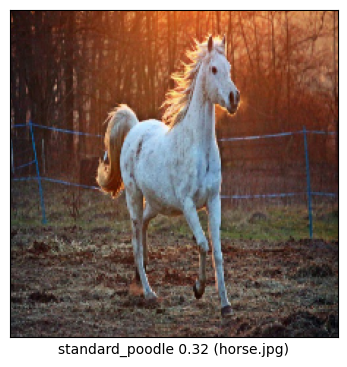

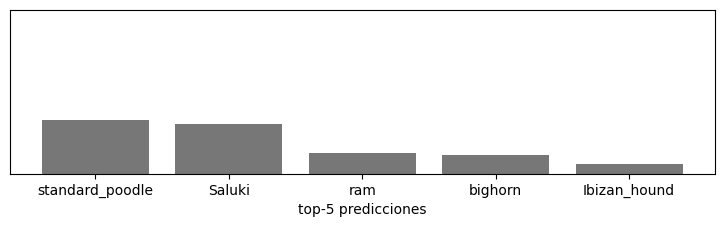

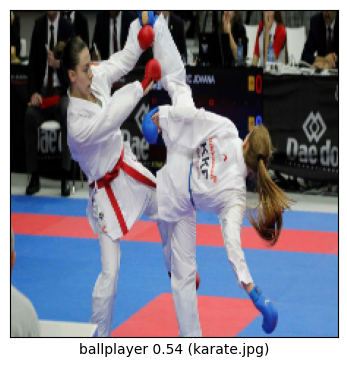

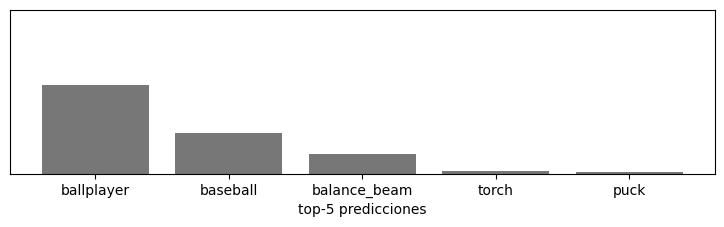

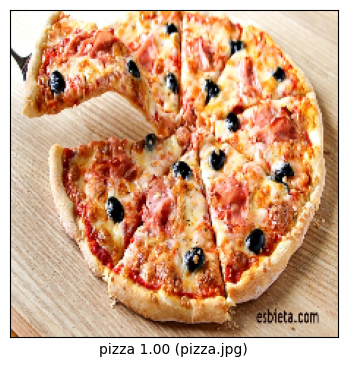

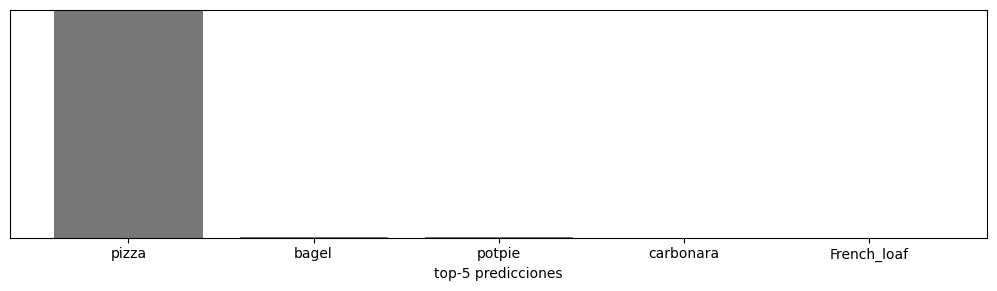

In [60]:
num_rows = 8
num_cols = 1
num_images = num_rows * num_cols

#plt.figure(figsize=(40, 40))

preds = base_model.predict(x_test)

# decode the results into a list of tuples (class, description, probability)
decodes = decode_predictions(preds, top=5)

for i,j in enumerate(decodes):
    prediction_proba = []
    predicted_classes = []
    for decode in j:
        prediction_proba.append(decode[2])
        predicted_classes.append(decode[1])
    plt.figure(figsize=(40, 40))
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i,predicted_classes[0],prediction_proba[0],tipos[i],x_figs)
    plt.figure(figsize=(20, 20))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(prediction_proba, predicted_classes)
plt.tight_layout()
plt.show()

## VGG16
En este caso vamos a importar la red VGG16, que utilizaremos como red preentrenada y completaremos con una fully connected layer. 

<img src="./img/vgg16.png" alt="drawing" width="150"/>

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split

IM_SIZE=64

TRAIN_PATH = './data/train/'
filenames = os.listdir(TRAIN_PATH)
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)
    
df = pd.DataFrame({
    'filenames': filenames,
    'category': categories
})

train_df, validate_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [63]:
from keras.preprocessing.image import ImageDataGenerator


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40, # Rotacion en grados
                                   width_shift_range = 0.2, # Desplazamiento a lo ancho
                                   height_shift_range = 0.2,
                                   shear_range = 0.2, # Intensidad del angulo de rotacion
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale = 1.0/255. )

In [64]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    TRAIN_PATH, # Donde busscar todo esto
                                                    x_col='filenames', # Nombres de archivos
                                                    y_col='category', # Target
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (IM_SIZE, IM_SIZE))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              TRAIN_PATH,
                                                              x_col='filenames',
                                                              y_col='category',
                                                              batch_size = 20,
                                                              class_mode = 'binary',
                                                              target_size = (IM_SIZE, IM_SIZE))

Found 5260 validated image filenames belonging to 2 classes.
Found 1316 validated image filenames belonging to 2 classes.


In [116]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (IM_SIZE, IM_SIZE, 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')

# No queremos que VGG16 entrenen en el fit
for layer in base_model.layers:
    layer.trainable = False
    
##### FULLY CONNECTED LAYER #####
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [135]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [118]:
vgghist = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100, # Cantidad de batches en los que divide el epoch
                    epochs = 10)

Epoch 1/10
100/100 [==============================] - 42s 415ms/step - loss: 0.6526 - acc: 0.6780 - val_loss: 0.4957 - val_acc: 0.7561
Epoch 2/10
100/100 [==============================] - 41s 415ms/step - loss: 0.5751 - acc: 0.7055 - val_loss: 0.4692 - val_acc: 0.7842
Epoch 3/10
100/100 [==============================] - 40s 398ms/step - loss: 0.5411 - acc: 0.7175 - val_loss: 0.4646 - val_acc: 0.7690
Epoch 4/10
100/100 [==============================] - 39s 393ms/step - loss: 0.5240 - acc: 0.7495 - val_loss: 0.4575 - val_acc: 0.7812
Epoch 5/10
100/100 [==============================] - 42s 420ms/step - loss: 0.5126 - acc: 0.7485 - val_loss: 0.4444 - val_acc: 0.7842
Epoch 6/10
100/100 [==============================] - 39s 391ms/step - loss: 0.5051 - acc: 0.7555 - val_loss: 0.4401 - val_acc: 0.7895
Epoch 7/10
100/100 [==============================] - 41s 408ms/step - loss: 0.5147 - acc: 0.7455 - val_loss: 0.4405 - val_acc: 0.7880
Epoch 8/10
100/100 [==============================] - 6

In [119]:
TEST_PATH = "./data/test/"

def read_data(path, im_size):
    X = []
    Y = []

    for file in os.listdir(path):
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (im_size,im_size))
        
        X.append(smallimage/255.)
        
        category = file.split('.')[0]
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IM_SIZE)
X_test, y_test = read_data(TEST_PATH, IM_SIZE)





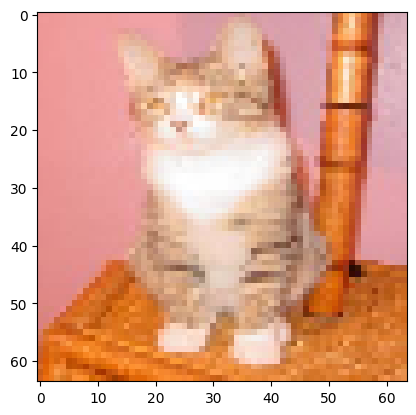

In [120]:
plt.imshow(X_train[12])

In [121]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

108/108 [==============================] - 33s 308ms/step - loss: 0.4471 - acc: 0.7894
test loss, test acc: [0.44707319140434265, 0.7893518805503845]


Aquí no acaba la cosa, ahora es cuando podemo liberar las capas del modelo pretrained y reentrenarlo con nuestro train

In [74]:
for indice, layer in enumerate(model.layers):
    print("Capa %d: %s" %(indice, layer.name))

Capa 0: input_2
Capa 1: block1_conv1
Capa 2: block1_conv2
Capa 3: block1_pool
Capa 4: block2_conv1
Capa 5: block2_conv2
Capa 6: block2_pool
Capa 7: block3_conv1
Capa 8: block3_conv2
Capa 9: block3_conv3
Capa 10: block3_pool
Capa 11: block4_conv1
Capa 12: block4_conv2
Capa 13: block4_conv3
Capa 14: block4_pool
Capa 15: block5_conv1
Capa 16: block5_conv2
Capa 17: block5_conv3
Capa 18: block5_pool
Capa 19: flatten
Capa 20: dense
Capa 21: dropout
Capa 22: dense_1


In [114]:
for layer in model.layers[15:19]:
    print(layer.name)
    layer.trainable = True

block5_conv1
block5_conv2
block5_conv3
block5_pool


In [112]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              learn_rate = 0.03,
              metrics = ['accuracy'])

In [102]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)


In [103]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size= 0.2)

In [113]:
model.fit(X_train,y_train,
        validation_data= (X_val,y_val),
        batch_size = 10,
        steps_per_epoch = 10, # Cantidad de batches en los que divide el epoch
        epochs = 10)

Epoch 1/10
10/10 [==============================] - 22s 2s/step - loss: 0.6895 - accuracy: 0.5500 - val_loss: 0.7430 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 0.6805 - accuracy: 0.6400 - val_loss: 0.7451 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 24s 3s/step - loss: 0.6852 - accuracy: 0.5900 - val_loss: 0.7479 - val_accuracy: 0.0000e+00
Epoch 4/10
 4/10 [===========>..................] - ETA: 4s - loss: 0.6812 - accuracy: 0.6250

KeyboardInterrupt: 

### Inception

In [15]:
IM_SIZE=150

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    TRAIN_PATH,
                                                    x_col='filenames',
                                                    y_col='category',
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (IM_SIZE, IM_SIZE))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              TRAIN_PATH,
                                                              x_col='filenames',
                                                              y_col='category',
                                                              batch_size = 20,
                                                              class_mode = 'binary',
                                                              target_size = (IM_SIZE, IM_SIZE))

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (IM_SIZE, IM_SIZE, 3),
                         include_top = False,
                         weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 22s 0us/step


In [17]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

inc_history = model.fit(train_generator,
                      validation_data = validation_generator,
                      steps_per_epoch = 100,
                      epochs = 10)


Epoch 1/10
100/100 [==============================] - 100s 977ms/step - loss: 9.6299 - acc: 0.8345 - val_loss: 0.5941 - val_acc: 0.9425
Epoch 2/10
100/100 [==============================] - 101s 1s/step - loss: 0.7248 - acc: 0.8880 - val_loss: 0.1086 - val_acc: 0.9575
Epoch 3/10
100/100 [==============================] - 100s 1s/step - loss: 0.3438 - acc: 0.8895 - val_loss: 0.1658 - val_acc: 0.9402
Epoch 4/10
100/100 [==============================] - 110s 1s/step - loss: 0.2826 - acc: 0.9030 - val_loss: 0.1040 - val_acc: 0.9607
Epoch 5/10
100/100 [==============================] - 112s 1s/step - loss: 0.2312 - acc: 0.9115 - val_loss: 0.1037 - val_acc: 0.9585
Epoch 6/10
100/100 [==============================] - 93s 934ms/step - loss: 0.2303 - acc: 0.9175 - val_loss: 0.0993 - val_acc: 0.9592
Epoch 7/10
100/100 [==============================] - 93s 936ms/step - loss: 0.2678 - acc: 0.9005 - val_loss: 0.0927 - val_acc: 0.9615
Epoch 8/10
100/100 [==============================] - 93s 930m

<AxesSubplot: >

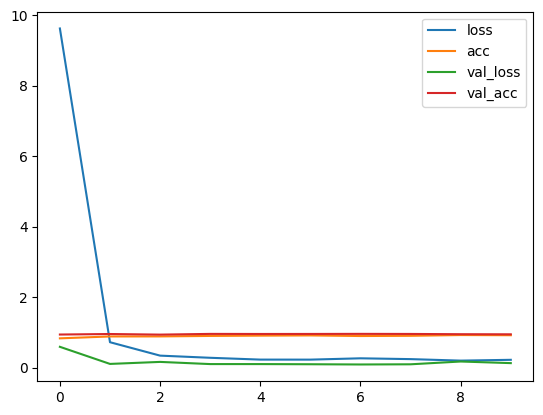

In [18]:
pd.DataFrame(inc_history.history).plot()

## ResNet50V2 sin entrenar

In [133]:
IM_SIZE=32

base_model = ResNet50V2(input_shape=(IM_SIZE, IM_SIZE,3),
                        include_top=False,
                        classifier_activation="softmax")

94674944/94668760 [==============================] - 44s 0us/step


In [134]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    TRAIN_PATH,
                                                    x_col='filenames',
                                                    y_col='category',
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (IM_SIZE, IM_SIZE))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              TRAIN_PATH,
                                                              x_col='filenames',
                                                              y_col='category',
                                                              batch_size = 20,
                                                              class_mode = 'binary',
                                                              target_size = (IM_SIZE, IM_SIZE))

Found 5260 validated image filenames belonging to 2 classes.
Found 1316 validated image filenames belonging to 2 classes.


In [135]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)


Epoch 1/10
100/100 [==============================] - 125s 1s/step - loss: 0.8080 - acc: 0.5520 - val_loss: 0.6865 - val_acc: 0.5502
Epoch 2/10
100/100 [==============================] - 126s 1s/step - loss: 0.7233 - acc: 0.5640 - val_loss: 0.6984 - val_acc: 0.6071
Epoch 3/10
100/100 [==============================] - 130s 1s/step - loss: 0.6792 - acc: 0.6060 - val_loss: 0.6775 - val_acc: 0.6406
Epoch 4/10
100/100 [==============================] - 130s 1s/step - loss: 0.6812 - acc: 0.6265 - val_loss: 0.6875 - val_acc: 0.6474
Epoch 5/10
100/100 [==============================] - 129s 1s/step - loss: 0.6738 - acc: 0.6290 - val_loss: 1.8932 - val_acc: 0.6421
Epoch 6/10
100/100 [==============================] - 130s 1s/step - loss: 0.6732 - acc: 0.6320 - val_loss: 1.5917 - val_acc: 0.6307
Epoch 7/10
100/100 [==============================] - 127s 1s/step - loss: 0.6613 - acc: 0.6405 - val_loss: 5.9469 - val_acc: 0.6368
Epoch 8/10
100/100 [==============================] - 123s 1s/step - 

In [136]:
history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)


Epoch 1/10
100/100 [==============================] - 112s 1s/step - loss: 0.6270 - acc: 0.6780 - val_loss: 1.0451 - val_acc: 0.7143
Epoch 2/10
100/100 [==============================] - 113s 1s/step - loss: 0.6042 - acc: 0.6780 - val_loss: 0.9609 - val_acc: 0.7340
Epoch 3/10
100/100 [==============================] - 113s 1s/step - loss: 0.6506 - acc: 0.6730 - val_loss: 1.0535 - val_acc: 0.7386
Epoch 4/10
100/100 [==============================] - 113s 1s/step - loss: 0.6320 - acc: 0.6695 - val_loss: 0.5738 - val_acc: 0.7530
Epoch 5/10
100/100 [==============================] - 113s 1s/step - loss: 0.6159 - acc: 0.6930 - val_loss: 0.9917 - val_acc: 0.7515
Epoch 6/10
100/100 [==============================] - 113s 1s/step - loss: 0.6194 - acc: 0.7015 - val_loss: 0.6849 - val_acc: 0.7356
Epoch 7/10
100/100 [==============================] - 113s 1s/step - loss: 0.5911 - acc: 0.7140 - val_loss: 0.7470 - val_acc: 0.7508
Epoch 8/10
100/100 [==============================] - 113s 1s/step - 

Fuentes de modelos pretrained (algunos son finetuneables o reentrenables otros no):  
Tensorflow: https://www.tensorflow.org/hub?hl=es-419    
Keras: https://keras.io/api/applications/  
Hugging Face: https://huggingface.co/transformers/v3.3.1/pretrained_models.html  
